In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import pulser

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform
from pulser_simulation import Simulation

%matplotlib inline

## Define Pulser Gates

In [2]:
class Gate:
    """ A generic gate over an arbitrary set of qubits. """
    
    def __call__(self, seq):
        """ Add the gate pulses and shifts to the given sequence.
        """
        raise NotImplementedError("Gate sub-classes must implement __call__.")

    
class RamanPulseGate(Gate):
    """ A generic single Raman pulse gate.
    
        Parameters
        ----------
        target : str 
            The qubit to apply the pulse to.
        **kw : dict
            Additional gate parameters.
    """
    def __init__(self, target, amplitude, detuning, phase, postphase=0, duration=252):
        self.target = target
        self.amplitude = amplitude
        self.detuning = detuning
        self.phase = phase
        self.postphase = postphase
        self.duration = duration

    def __call__(self, seq):
        waveform = BlackmanWaveform(self.duration, self.amplitude)
        pulse = Pulse.ConstantDetuning(
            waveform,
            detuning=self.detuning,
            phase=self.phase,
            post_phase_shift=self.postphase,
        )

        seq.target(self.target, "raman")
        seq.add(pulse, "raman", "wait-for-all")
        

class PhaseShiftGate(Gate):
    """ A generic single phase shift gate.
    
        Parameters
        ----------
        target : str 
            The qubit to apply the pulse to.
        phase : float
            The angle of the Z-axis phase rotation to apply in radians.
    """
    def __init__(self, target, phase):
        self.target = target
        self.phase = phase
        
    def __call__(self, seq):
        seq.phase_shift(self.phase, self.target, basis="digital") 

In [3]:
class U(RamanPulseGate):
    """ A generic unitary gate about an axis in the X-Y plane.

        U(gamma, theta, phi) = Rz(gamma) Rx(theta) Rz(phi)
                             = Rz(gamma+phi) Rz(-phi) Rx(theta) Rz(phi)
    """
    def __init__(self, target, gamma, theta, phi):
        super().__init__(
            target=target,
            amplitude=theta,
            detuning=0,
            phase=phi,
            postphase=gamma + phi,
        )


class Rx(U):
    """ An Rx(theta) gate. """
    def __init__(self, target, theta):
        if theta >= 0:
            # Rz(0) Rx(theta) Rz(0) = Rx(theta)
            super().__init__(target, 0, theta, 0)
        else:
            # Rz(-pi) Rx(-theta) Rz(+pi) = Rx(theta)
            super().__init__(target, -np.pi, -theta, np.pi)


class Ry(U):
    """ An Ry(theta) gate. """
    def __init__(self, target, theta):
        if theta >= 0:
            # Rz(pi/2) Rx(theta) Rz(-pi/2) = Ry(theta)
            super().__init__(target, np.pi / 2, theta, -np.pi / 2)
        else:
            # Rz(-pi/2) Rx(-theta) Rz(pi/2) = Ry(theta)
            super().__init__(target, -np.pi / 2, -theta, np.pi / 2)
            
            
class Rz(PhaseShiftGate):
    """ An Rz(theta) gate. """
    def __init__(self, target, theta):
        super().__init__(target, theta)

## Define theoretical gates

In [4]:
def rx_theory(theta):
    """ Rx(theta). """
    return qutip.Qobj([
        [np.cos(theta/2), -np.sin(theta/2)*1j],
        [-np.sin(theta/2)*1j,np.cos(theta/2)],
    ])


def ry_theory(theta):
    """ Ry(theta). """
    return qutip.Qobj([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2), np.cos(theta/2)],
    ])


def rz_theory(theta):
    """ Rz(theta). """
    return qutip.Qobj([
        [np.exp(-1j * theta / 2), 0],
        [0, np.exp(1j * theta / 2)],
    ])

## Pulser and theoretical simulation

In [5]:
def sim_pulser(psi, gates):
    """ Run pulser with the given initial state and gates. """
    reg = Register({"q1": np.array([0, 0])})
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("raman", "raman_local", "q1")
    
    for g in gates:
        g(seq)

    sim = Simulation(seq, 0.3)
    sim.initial_state = psi

    result = sim.run()

    return seq, result

In [6]:
def sim_theory(psi, gates, steps=10):
    """ Calculate an analytical result to check the pulser results against. """
    theory_states = []

    for g, theta in gates:
        theory_states.extend(
            g(t) * psi
            for t in np.linspace(0, theta, steps)
        )
        psi = g(theta) * psi
        
    return theory_states

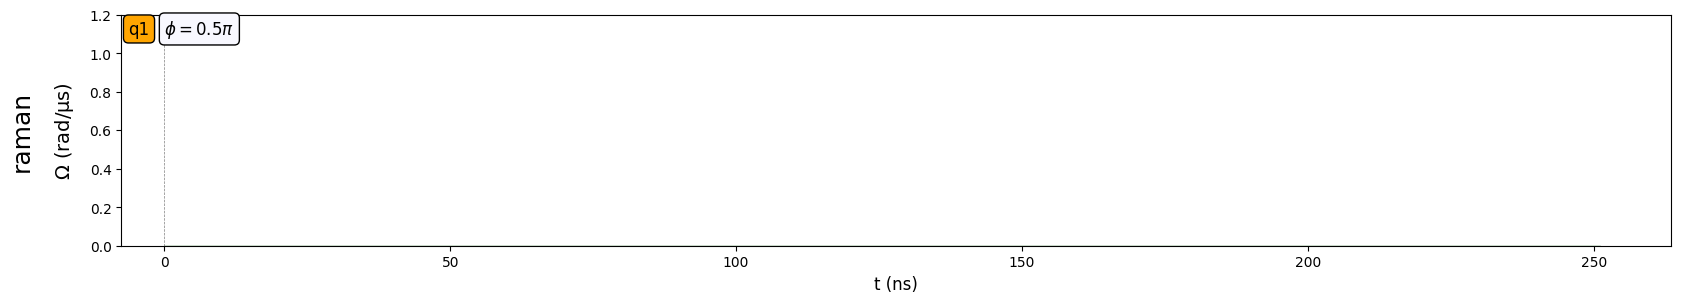

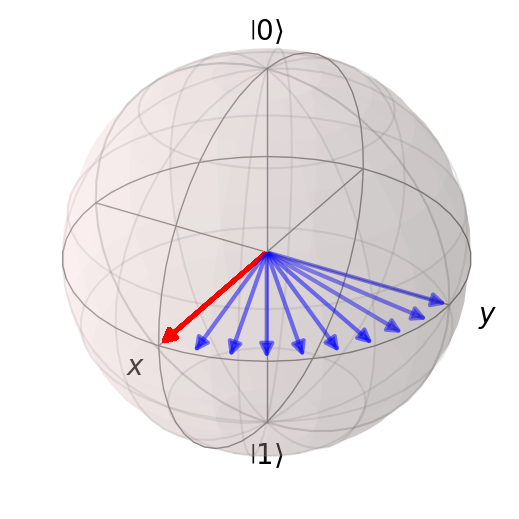

In [7]:
theta = np.pi / 2
psi = (qutip.ket("1") + qutip.ket("0")).unit()

theory_states = sim_theory(psi, [
    (rz_theory, theta),
])

gates = [
    Rz("q1", theta),
    Rx("q1", 0),
]

seq, result = sim_pulser(psi, gates)

seq.draw(draw_phase_shifts=True)

b = qutip.Bloch()
b.vector_color = ["b"] * len(theory_states) + ["r"] * len(result.states)
b.vector_alpha = list(np.linspace(0.5, 0.7, len(theory_states) + len(result.states)))
b.add_states(theory_states)
b.add_states(result.states)
b.show()

In [8]:
result.get_final_state()

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]

In [9]:
seq.current_phase_ref("q1")

1.5707963267948966

In [10]:
theory_states[-1]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.5-0.5j]
 [0.5+0.5j]]

In [11]:
rz_theory(theta=seq.current_phase_ref("q1")) * result.get_final_state()

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.5-0.5j]
 [0.5+0.5j]]